In the 'markdown cell' below  replace the `???` with the names of those in your group.

???

# Assignment (part 1): classification of cell morphological changes with LeNet
_by Phil Harrison (February 2021)_
#### Inspiration
This step by step exercise was inspired by Andrew Ng's **Deep learning** Coursera specialization (https://www.coursera.org/specializations/deep-learning) . This assignment will take you through a machine learning workflow which includes reading datasets, creating and compiling models, training models on datasets, and predicting on the validation sets (for model comparisons). Much of the experience you accumualted during the labs from yesterday and the day before will come in useful here.

#### Datasets
The specific dataset we will use is a subset of the bbbc021v1 MoA dataset (http://mct.aacrjournals.org/content/9/6/1913) available from the Broad Bioimage Benchmark Collection (https://www.nature.com/articles/nmeth.2083). We chose to only use a subset of this data (based on only the six main MoAs) in order that the models we will fit below would not take too long to train.

#### Importance
After you've completed this assignment you will know how to develop and utilize advanced machine learning models (in this case convlutional neural networks (CNNs) applied to high content cell images). Traditional approaches for classyfing such biological cell-images involve complex workflows, with many steps requiring manual implementation. The more modern neural network approach (made possible through the better hardware available today, most notably via GPUs) can perform equally well and often better than the traditional approaches. What's more these CNNs, based merely on the pixel-intensities of the images, require significantly less domain expertise.

#### Note 1
Using the entire MoA dataset, transfer learning and data augmentation is a preferable way to more fully explore this data (as was done in the paper written by Alexander Kensert - a former student from the same PB-seq masters course you are now on! (https://journals.sagepub.com/doi/10.1177/2472555218818756)). This paper was discussed during the lectures.

Adding transfer learning to the models will be explored in part 3 of the assignemt. This third part should be attempted by those of you that would like to attain a **VG mark** for the assignment. To attain a **G mark** only parts 1 and 2 need be completed.

#### Note 2
For the assignment we will split the data into a training and validation set and will only optimize our performance on the validation set. Although from the work with the oral cancer data you saw that it is genrally best to keep out a test set on which to make a final evaluation of your chosen model.

## Load packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Helper libraries
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import pandas as pd
from PIL import Image

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
print(tf.__version__)

2.1.0


## Functions
Don't worry too much about the code in the functions below, but you might want to go through when they are called later on so that you roughly understand what they're doing.

In [2]:
def load_dataset():
    dirname = 'bbbc021v1_images'
    x_orig = np.zeros((660, 256, 256, 3), dtype=np.float32)

    for f in range(x_orig.shape[0]):
        img    = Image.open(dirname + '/bbbc021v1_%s.png' % str(f))
        img    = np.array(img)
        x_orig[f] = img

    labels = pd.read_csv('bbbc021v1_labels.csv',
                          usecols=["compound", "concentration", "moa"],
                          sep=";")
    y_orig = np.array(labels['moa'])

    return x_orig, y_orig

def convert_to_one_hot(y, C):
    moa_dict = {'Aurora kinase inhibitors': 0, 'Cholesterol-lowering': 1,
                'Eg5 inhibitors': 2, 'Protein synthesis': 3, 'DNA replication': 4, 'DNA damage': 5}

    y = np.asarray([moa_dict[item] for item in y])
    y = np.eye(C)[y]
    y = y.astype('float32')

    return y

def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15, 5), facecolor='w')
    ax = fig.add_subplot(131)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['train', 'valid'], loc='upper right')
    
    ax = fig.add_subplot(132)
    ax.plot(np.log(model_history.history['loss']))
    ax.plot(np.log(model_history.history['val_loss']))
    ax.set(title=model_name + ': Log model loss', ylabel='Log loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')    

    ax = fig.add_subplot(133)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['train', 'valid'], loc='upper right')
    plt.show()
    plt.close()

def plot_confusion_matrix(cm, classes, model_name,
                          cmap=plt.cm.Blues):
    title = model_name + ': Confusion Matrix'
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def valid_evaluate(model, model_name):
    y_pred = model.predict(X_valid)
    y_pred = y_pred.argmax(axis=-1)
    y_true = Y_valid.argmax(axis=-1)
    
    class_names = ['Aur', 'Ch', 'Eg5', 'PS', 'DR', 'DS']
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(15,5), facecolor='w')
    plot_confusion_matrix(cnf_matrix, classes=class_names, model_name=model_name)
    plt.show()
    plt.close()
    
    print('')
    print('classification report for validation data:')
    print(classification_report(y_true, y_pred, digits=3))

## Read dataset

In [3]:
X_orig, y_orig = load_dataset()

print("Shape of X_orig = " + str(X_orig.shape))
print("Shape of y_orig = " + str(y_orig.shape))

Shape of X_orig = (660, 256, 256, 3)
Shape of y_orig = (660,)


## One hot encoding of targets and standardization of images

In [4]:
Y = convert_to_one_hot(y_orig, 6)
X = X_orig/255.

print("Shape of Y_orig = " + str(Y.shape))

Shape of Y_orig = (660, 6)


## Split data into training and validation sets
We will use 500 of the images for training and the remaining 160 for validation.

In [5]:
n_train = 500

random.seed(5026)
indices = np.arange(len(Y))
random.shuffle(indices)

X_train, X_valid = X[indices[:n_train]], X[indices[n_train:]]
Y_train, Y_valid = Y[indices[:n_train]], Y[indices[n_train:]]

## Plot samples of the data

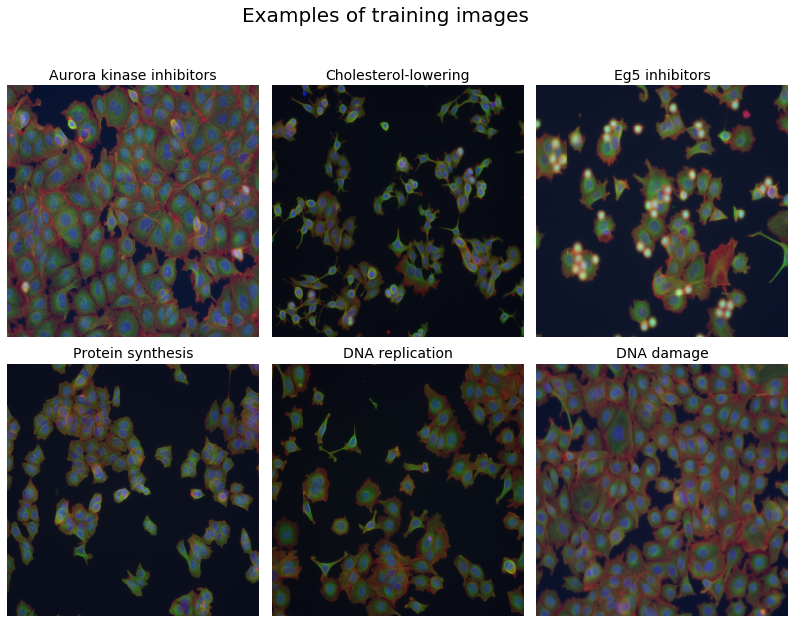

In [6]:
# Run cell to plot few example images of the training set
fig, ax = plt.subplots(2, 3, figsize=(14, 10))
fig.suptitle("Examples of training images", fontsize=20)
axes = ax.ravel()
for i in range(len(axes)):
    idx = np.where(np.argmax(Y_train, axis=1) == i)[0]
    s_idx = np.random.choice(idx)
    img = (X_train[s_idx]*255).astype("uint8")
    axes[i].set_title(y_orig[indices][s_idx], fontsize=14)
    axes[i].imshow(img)
    axes[i].set_axis_off()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
plt.close()

## CNN (LeNet inspired)

In this lab you will learn how to implement your own CNN for classifying cell phenotypes. You will be using the open-source machine learning framework TensorFlow (https://www.tensorflow.org) to do so.

Convolutional Neural Networks (CNNs) use convolutions instead of the normal fully connected layers, which have proven to be highly successful for image recognition tasks. By convolving filters on the input layer and outputting the results to the next layer, the CNN "detects" (or learns) features at different levels of abstraction throughout the network. With lower-level abstractions (like edges and blobs) in the early layers, and higher-level abstractions (like cells) in deeper layers. Figure 1 shows the LeNet inspired CNN that we will shortly turn into TensorFlow code. It has 3 convolutional layers, 3 max pooling layers, and two final fully connected layers.

<p>
    <img src="figs/conv.png" alt="drawing" style="width:1200px;"/>
    <center>Figure 1. LeNet inspired CNN that you will implement.</center>
</p>


If you're getting stuck or stumble upon problems, don't hesitate to use Google or similar to search for answers. There's plenty of information out there regarding TensorFlow (and Keras - the default language of Tensorflow 2) implementations. Good places to look:
* https://www.tensorflow.org
* https://keras.io 
* https://keras.io/examples/

Finally, make use of the lecture notes and previous labs and try to think carefully about what you're actually implementing.

## TASK 1: Coding LeNet
Replace the `???` parts in the cell below with your own code. Start by defining the input shape and then try to code in the variant of LeNet shown above in Figure 1. The final line of your code should be a dense layer with a softmax activation. Once you have your code ready run the cell and see if your model summary matches ours (see below). Note, the stride of 2 for the first convolutional layer is something you should define within the braces of `layers.Conv2D(...)` along with the other arguments you are now used to. You can press `STIFT+TAB` from inside the braces to see the aruments that can be passed. Also pay attention to how the dimensions above change from one part of the model to the next - with the max pooling we don't always use the defualt pool size of `(2, 2)`. To compensate for over-fitting add a dropout layer prior to your prediction layer with a dropout rate of `0.2`. Name your model `LeNet`.

### Define and sumarise the LeNet model

In [7]:
# define the model
num_classes = 6

inps = layers.Input((256, 256, 3)) # input image dimensions

# convolution and pooling layers
x = layers.Conv2D(16, kernel_size=(5, 5), strides=2, padding='same', activation='relu')(inps)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, kernel_size=(5, 5), strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(4, 4))(x)
x = layers.Conv2D(64, kernel_size=(5, 5), strides=1, padding='same',activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(4, 4))(x)

# fully connected layers
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
preds = layers.Dense(num_classes, activation='softmax')(x)

LeNet = models.Model(inputs=inps, outputs=preds)
LeNet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0     

### Did you define LeNet correctly?
At the end of the summary you should see the following:

Total params: 1,121,062

Trainable params: 1,121,062

Non-trainable params: 0

### Question:
In the first layer you will see in the number of parameters/weights to estimate/train is 1216. How is this number calculated? Replace the `???` in the 'markdown' cell below with your answer.

???

## Compile the LeNet model

In [8]:
lr = 0.001
LeNet.compile(optimizer=optimizers.Adam(lr=lr), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit and evaluate the LeNet model

Train on 500 samples, validate on 160 samples
Epoch 1/30
500/500 - 3s - loss: 1.6151 - accuracy: 0.3320 - val_loss: 1.2635 - val_accuracy: 0.4000
Epoch 2/30
500/500 - 0s - loss: 1.1730 - accuracy: 0.4420 - val_loss: 1.0848 - val_accuracy: 0.4250
Epoch 3/30
500/500 - 0s - loss: 1.0512 - accuracy: 0.4920 - val_loss: 1.0666 - val_accuracy: 0.5125
Epoch 4/30
500/500 - 0s - loss: 0.9328 - accuracy: 0.5660 - val_loss: 0.9503 - val_accuracy: 0.5562
Epoch 5/30
500/500 - 0s - loss: 0.7926 - accuracy: 0.6680 - val_loss: 0.9588 - val_accuracy: 0.6125
Epoch 6/30
500/500 - 0s - loss: 0.6595 - accuracy: 0.7340 - val_loss: 0.8200 - val_accuracy: 0.6375
Epoch 7/30
500/500 - 0s - loss: 0.7266 - accuracy: 0.6940 - val_loss: 1.0790 - val_accuracy: 0.4875
Epoch 8/30
500/500 - 0s - loss: 0.6212 - accuracy: 0.7420 - val_loss: 0.8449 - val_accuracy: 0.6625
Epoch 9/30
500/500 - 0s - loss: 0.4342 - accuracy: 0.8140 - val_loss: 0.7694 - val_accuracy: 0.6938
Epoch 10/30
500/500 - 0s - loss: 0.3660 - accuracy: 0.

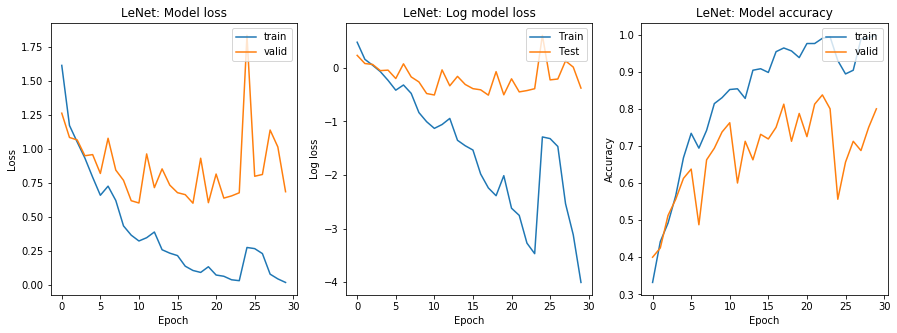

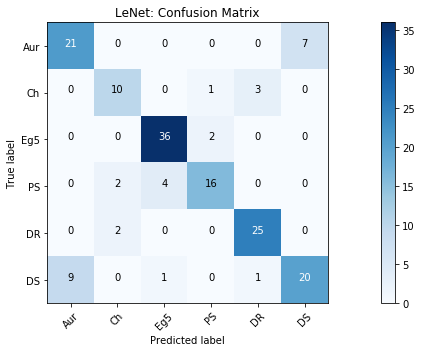


classification report for validation data:
              precision    recall  f1-score   support

           0      0.700     0.750     0.724        28
           1      0.714     0.714     0.714        14
           2      0.878     0.947     0.911        38
           3      0.842     0.727     0.780        22
           4      0.862     0.926     0.893        27
           5      0.741     0.645     0.690        31

    accuracy                          0.800       160
   macro avg      0.790     0.785     0.785       160
weighted avg      0.798     0.800     0.797       160



In [9]:
batch_size = 32
n_epochs = 30

history = LeNet.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=n_epochs,
                    validation_data=(X_valid, Y_valid),
                    verbose=2)

plot_history(history, 'LeNet')
valid_evaluate(LeNet, 'LeNet')

## Multiple runs of the same model
Re-running the model above, due to stochasticity in the local minima that the model achieves, will give different results. To get a more robust assessment of our model re-run it 5 times and compute the mean of the 'weighted avg f1-score' from the classification report. In the code cell below write each of these 5 values and compute their mean.

To re-run the model properly you need to rerun the model definition, model compiling and model fitting code cells above.

When I ran this model five times I got the following result for the mean 'weighted avg f1-score':

(0.707 + 0.774 + 0.723 + 0.834 + 0.797) / 5  = 0.767